In [1]:
# imports
import gzip
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reads stats

## Number of reads per sample

In [2]:
# FUNCTIONS

# paths to the individual gz files for each sample

def get_paths(directory, extension='.fastq.gz'):
    """
    Retrieve paths to individual gzip files for each sample.

    Args:
        directory (str): Path to the directory containing the files.

    Returns:
        list: A list of file paths to the individual gzip files for each sample.
    """
    all_files = os.listdir(directory)
    gz_files = [file for file in all_files if file.endswith(extension)]
    gz_paths = [directory + path for path in gz_files]
    return gz_paths


# counting the number of reads in the raw reads files

def count_seqs(gz_paths):
    """
    Count the number of reads in the raw read files.

    Args:
        gz_paths (list): A list of file paths to the raw read files.

    Returns:
        dict: A dictionary where the keys are sample names (derived from file names) and
        the values are the corresponding number of sequences in each raw read file.
    """
    output = {}
    for file_ in gz_paths:
        with gzip.open(file_,'rt') as f:
            num_lines = 0
            for line in f:
                num_lines += 1
            num_seqs = num_lines / 4
            file_path = file_.split("/")[-1]
            file_name = file_path.split(".")[0].split('_')[0]
            output[file_name] = num_seqs     
    return output

In [ ]:
pacbio = "../raw_data/PacBio/"
seq_paths = [f'{pacbio}/Suthaus_2022_Full18S/cell1/',
             f'{pacbio}/Suthaus_2022_Full18S/cell2/', 
             f'{pacbio}/Suthaus_2022_Full18S/cellCombined/', 
             f'{pacbio}/Suthaus_2022_rDNA/cell/']

num_read_data = {}
for seq_path in seq_paths:
    gz_paths = get_paths(seq_path)
    run_name = seq_path.split('/')[-3].split('_')[-1]
    cell_name = seq_path.split('/')[-2]
    sample_name = run_name + '_' + cell_name
    num_read_data[sample_name] = count_seqs(gz_paths)

In [ ]:
num_read_data['Full18S_cell1']

In [ ]:
df_reads = pd.DataFrame.from_dict(num_read_data)
df_reads = df_reads.dropna()
df_reads = df_reads.astype(int)

In [ ]:
df_reads

In [ ]:
df_reads['most_reads'] = df_reads.idxmax(axis=1)

In [ ]:
df_reads

In [ ]:
# Plotting number of reads: short vs. long fragment 



# adjusting the data table for plotting
df_reads_plot = df_reads[['Full18S_cellCombined', 'rDNA_cell']]
df_reads_plot = df_reads_plot.reset_index()
df_reads_plot = df_reads_plot.rename(columns={'index': 'sample', 
                                              'Full18S_cellCombined': 'short_fragment', 
                                              'rDNA_cell': 'long_fragment'})
df_reads_plot = df_reads_plot.melt(id_vars=['sample'], value_vars=['short_fragment', 'long_fragment'])


# plotting code
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
plot = sns.barplot(data=df_reads_plot, x='sample', y="value", hue='variable')
plot.set(xlabel='', 
         ylabel = 'number of reads',
         title ='Number of reads: short vs. long fragment')
sns.despine()

# adjusting legend
h, l = plot.get_legend_handles_labels()
plot.legend(handles=h, 
                  labels=['short (18S)', 'long (rDNA)'], 
                  title='Fragment', 
                  loc="upper right", 
                  frameon=False);

path = '../raw_data/OTU_results/Suthaus_2022'
# save
plt.savefig(f"{path}/number_of_reads_comparison.png", dpi=300, transparent=False)

## Length of the reads

In [ ]:
# counting the number of reads in the raw reads files

path = '../raw_data/PacBio/Suthaus_2022_rDNA/cell/A3_21R.hifi_reads.fastq.gz'


for file_ in gz_paths:
    with gzip.open(file_,'rt') as f:
        short_reads = 0
        for line in f:
            num_lines += 1
        num_seqs = num_lines / 4
        file_path = file_.split("/")[-1]
        file_name = file_path.split(".")[0].split('_')[0]
        output[file_name] = num_seqs     
return output

In [ ]:
# Creating a function for counting reads based on the lenght 

path = '../raw_data/PacBio/Suthaus_2022_rDNA/cell/A3_21R.hifi_reads.fastq.gz'



def get_reads_length(path):
    reads_length = {'less_3000': 0, 
                    '3000_6000': 0, 
                    'more_6000': 0
                   }

    with gzip.open(path,'rt') as f:
        for line in f:
            line_cleaned = line.replace('\n', '')
            if line_cleaned.startswith(('A', 'C',  'T', 'G')) and line_cleaned.isalpha():
                if len(line_cleaned) < 3000:
                    reads_length['less_3000'] += 1
                if 3000 <= len(line_cleaned) <= 6000:
                    reads_length['3000_6000'] += 1
                if len(line_cleaned) > 6000:
                    reads_length['more_6000'] += 1
    return reads_length

In [ ]:
# Creating table with length distribution of the reads

directory = '../raw_data/PacBio/Suthaus_2022_rDNA/cell/'

paths = get_paths(directory)
data = {}

for path in paths:
    sample_name = path.split('/')[-1].split('.')[0].split('_')[0]
    data[sample_name] = get_reads_length(path)

df_length = pd.DataFrame.from_dict(data)
df_length = df_length.T
df_length = df_length.rename(columns={'less_3000': 'less_than_3000', 
                        '3000_6000': 'between_3000-6000', 
                        'more_6000': 'more_than_6000'})

In [ ]:
df_length

In [ ]:
# Plotting a length distribution of the reads 



# adjusting the data table for plotting
df_length_plot = df_length
df_length_plot = df_length_plot.reset_index()
df_length_plot = df_length_plot.rename(columns={'index': 'sample'})
df_length_plot = df_length_plot.melt(id_vars=['sample'], value_vars=['less_than_3000', 'between_3000-6000'])


# plotting code
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
plot = sns.barplot(data=df_length_plot, x='sample', y="value", hue='variable')
plot.set(xlabel='', 
         ylabel = 'number of reads',
         title ='Length distribution of the reads')
sns.despine();

# adjusting legend
h, l = plot.get_legend_handles_labels()
plot.legend(handles=h, 
                  labels=['less than 3000', 'between 3000 and 6000'], 
                  title='Length (nt)', 
                  loc="upper right", 
                  frameon=False);

path = '../raw_data/OTU_results/Suthaus_2022'
# save
plt.savefig(f"{path}/reads_length_distribution.png", dpi=300, transparent=False)

## Comparing number of reads after filtering the short ones

At first:

1. Run the cells in the **1.1 Number of reads per sample** to get the **df_reads** dataframe

2. Run the cells in the **1.2 Length of the reads** to get **reads_length** dataframe

In [ ]:
# creating dataframe

df_reads_filt = df_reads[['Full18S_cellCombined', 'sample']]
df_reads_filt['rDNA'] = df_length['between_3000-6000']
df_reads_filt = df_reads_filt.rename(columns = {'Full18S_cellCombined': '18S'})

In [ ]:
# Plotting number of reads: 18S vs. rDNA fragment after filtering based on the size


# adjusting the data table for plotting
df_reads_filt_plot = df_reads_filt.melt(id_vars=['sample'], value_vars=['18S', 'rDNA'])
df_reads_filt_plot


# plotting code
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
plot = sns.barplot(data=df_reads_filt_plot, x='sample', y="value", hue='variable')
plot.set(xlabel='', 
         ylabel = 'number of reads',
         title ='Number of reads: short vs. long fragment after filtering based on the length')
sns.despine()

# adjusting legend
h, l = plot.get_legend_handles_labels()
plot.legend(handles=h, 
                  labels=['short (18S)', 'long (rDNA)'], 
                  title='Fragment', 
                  loc="upper right", 
                  frameon=False);

path = '../raw_data/OTU_results/Suthaus_2022'
# save
plt.savefig(f"{path}/number_of_reads_comparison_filtered.png", dpi=300, transparent=False)

## Checking short reads

In [29]:
path = '../raw_data/PacBio/Suthaus_2022_rDNA/cell/A3_21R.hifi_reads.fastq.gz'

short_reads = []
read_id = ''
with gzip.open(path,'rt') as f:
    for line in f:
        line_cleaned = line.replace('\n', '')
        if ('@m54326U' in line_cleaned):
            read_id = line_cleaned
        if line_cleaned.isalpha() and len(line_cleaned) < 3900 and len(line_cleaned) > 3000: 
            short_reads.append(read_id.replace('@', '>'))
            short_reads.append(line_cleaned.strip())

In [30]:
short_reads

# open file in write mode
with open(r'short_reads_3000-3900.fasta', 'w') as fp:
    for item in short_reads:
        fp.write("%s\n" % item)

# Mawhash 2022 data

## Number of reads/OTUs during the downstream analysis

### Number of raw reads

In [3]:
# Creating a table (dataframe) re-using the custome get_paths and count_seqs functions
 
path = '../raw_data/PacBio/Jamy_2022_rDNA/cell/raw/'

paths = get_paths(path)
read_count = count_seqs(paths)

In [4]:
raw_count_df = pd.DataFrame(data=read_count, index=[0])
raw_count_df = raw_count_df.T
raw_count_df = raw_count_df.reset_index()
raw_count_df = raw_count_df.rename(columns = {'index': 'sample', 
                                              0: 'read_number'})
raw_count_df

,sample,read_number
0,ERR6454477,775615.0
1,ERR6454466,301806.0
2,ERR6454470,1543739.0
3,ERR6454463,627565.0
4,ERR6454476,761055.0
5,ERR6454464,456683.0
6,ERR6454465,519814.0
7,ERR6454469,950141.0
8,ERR6454473,511880.0
9,ERR6454474,642804.0


In [ ]:
# plotting
sns.barplot(data=raw_count_df, x='read_number', y='sample')

### Number of filtered reads

These are reads after running *data_filter_trim* script.
So the reads were:
- oriented
- trimmed
- filtered based on the quality and length

In [5]:
# Creating a table (dataframe) re-using the custome get_paths and count_seqs functions
 
path = '../raw_data/PacBio/Jamy_2022_rDNA/cell/filtered/'

paths = get_paths(path)
read_count = count_seqs(paths)


read_count_df = pd.DataFrame(data=read_count, index=[0])
read_count_df = read_count_df.T
read_count_df = read_count_df.reset_index()
read_count_df = read_count_df.rename(columns = {'index': 'sample', 
                                                0: 'read_number'})
read_count_df

,sample,read_number
0,ERR6454477,504793.0
1,ERR6454466,170210.0
2,ERR6454470,980905.0
3,ERR6454463,378803.0
4,ERR6454476,483659.0
5,ERR6454464,261126.0
6,ERR6454465,345583.0
7,ERR6454469,568268.0
8,ERR6454473,296155.0
9,ERR6454474,412772.0


In [ ]:
# plotting
sns.barplot(data=read_count_df, x='read_number', y='sample')

### Dereplicated reads

Reads after using the *tax_assign_nondenoised_02_dereplicate* script

In [6]:
# FUNCTION


# counting the number of reads in the raw reads files

def count_seqs_fasta(fasta_paths):
    """
    Count the number of reads in the raw read files.

    Args:
        gz_paths (list): A list of file paths to the raw read files.

    Returns:
        dict: A dictionary where the keys are sample names (derived from file names) and
        the values are the corresponding number of sequences in each raw read file.
    """
    output = {}
    for file_ in fasta_paths:
        with open(file_, 'rt') as f:
            num_lines = 0
            for line in f:
                num_lines += 1
            num_seqs = num_lines / 2
            file_name = file_.split("_")[-1].split('.')[0]
            output[file_name] = num_seqs     
    return output

In [19]:
# FUNCTION


# counting the number of reads in the raw reads files

def count_seqs_fasta(fasta_paths):
    """
    Count the number of reads in the raw read files.

    Args:
        gz_paths (list): A list of file paths to the raw read files.

    Returns:
        dict: A dictionary where the keys are sample names (derived from file names) and
        the values are the corresponding number of sequences in each raw read file.
    """
    output = {}
    for file_ in fasta_paths:
        with open(file_, 'rt') as f:
            num_seqs = 0
            for line in f:
                if line.startswith('>'):
                    num_seqs += 1
            file_name = file_.split("_")[-1].split('.')[0]
            output[file_name] = num_seqs     
    return output

In [7]:
# count all the reads
path = '../raw_data/denoise/Jamy_2022/rDNA/cell/'
paths = get_paths(path, extension='.fasta')
derep_count_df = count_seqs_fasta(paths)

In [ ]:
derep_count_df

In [8]:
# create a dataframe from the counting 
derep_df = pd.DataFrame(data=derep_count_df, index=[0])
derep_df = derep_df.T
derep_df = derep_df.reset_index()
derep_df = derep_df.rename(columns = {'index': 'sample', 
                                            0: 'derep_number'})

In [ ]:
comp_read_number = pd.merge(read_count_df, derep_df, on='sample')

In [ ]:
# Plotting number of reads comparison


# adjusting the data table for plotting
comp_read_number_plot = comp_read_number.melt(id_vars=['sample'], value_vars=['read_number', 'derep_number'])
comp_read_number_plot


# plotting code
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
plot = sns.barplot(data=comp_read_number_plot, y='sample', x="value", hue='variable')
plot.set(xlabel='', 
         ylabel = 'number of reads',
         title ='Number of reads: filtered vs. dereplicated')
sns.despine()

# adjusting legend
h, l = plot.get_legend_handles_labels()
plot.legend(handles=h, 
                  labels=['filtered', 'dereplicated'], 
                  title='', 
                  loc="lower right", 
                  frameon=False);

### Preclustered reads (99%)

In [20]:
# count all the otus
path = '../raw_data/OTU_clust/Jamy_2022/rDNA/cell/sim99/'
paths = get_paths(path, extension='.fasta')
otu_count = count_seqs_fasta(paths)

In [21]:
otu_count

{'ERR6454465': 7759,
 'ERR6454470': 8068,
 'ERR6454478': 2246,
 'ERR6454468': 9216,
 'ERR6454464': 8135,
 'ERR6454469': 11539,
 'ERR6454474': 13592,
 'ERR6454462': 10044,
 'ERR6454466': 2640,
 'ERR6454476': 51954,
 'ERR6454463': 5097,
 'ERR6454461': 9087,
 'ERR6454471': 5458,
 'ERR6454475': 3782,
 'ERR6454477': 7011,
 'ERR6454472': 1612,
 'ERR6454473': 14309,
 'ERR6454467': 2416}

In [22]:
# create a dataframe from the counting 
otu_count_df = pd.DataFrame(data=otu_count, index=[0])
otu_count_df = otu_count_df.T
otu_count_df = otu_count_df.reset_index()
otu_count_df = otu_count_df.rename(columns = {'index': 'sample', 
                                            0: 'otu_number'})

In [23]:
otu_count_df

,sample,otu_number
0,ERR6454465,7759
1,ERR6454470,8068
2,ERR6454478,2246
3,ERR6454468,9216
4,ERR6454464,8135
5,ERR6454469,11539
6,ERR6454474,13592
7,ERR6454462,10044
8,ERR6454466,2640
9,ERR6454476,51954


### Comparison: raw reads, filtered seqs, dereplicated seqs 

In [25]:
comp_df = raw_count_df.merge(read_count_df, on ='sample').merge(derep_df, on='sample').merge(otu_count_df, on='sample')
comp_df = comp_df.rename(columns = {'read_number_x': 'raw_reads', 
                                    'read_number_y': 'filtered_seqs', 
                                    'derep_number': 'derep_seqs', 
                                    'otu_number': 'otu_99'})
comp_df

,sample,raw_reads,filtered_seqs,derep_seqs,otu_99
0,ERR6454477,775615.0,504793.0,502207.0,7011
1,ERR6454466,301806.0,170210.0,169716.0,2640
2,ERR6454470,1543739.0,980905.0,943150.0,8068
3,ERR6454463,627565.0,378803.0,375633.0,5097
4,ERR6454476,761055.0,483659.0,481198.0,51954
5,ERR6454464,456683.0,261126.0,260566.0,8135
6,ERR6454465,519814.0,345583.0,345415.0,7759
7,ERR6454469,950141.0,568268.0,567138.0,11539
8,ERR6454473,511880.0,296155.0,294126.0,14309
9,ERR6454474,642804.0,412772.0,404139.0,13592


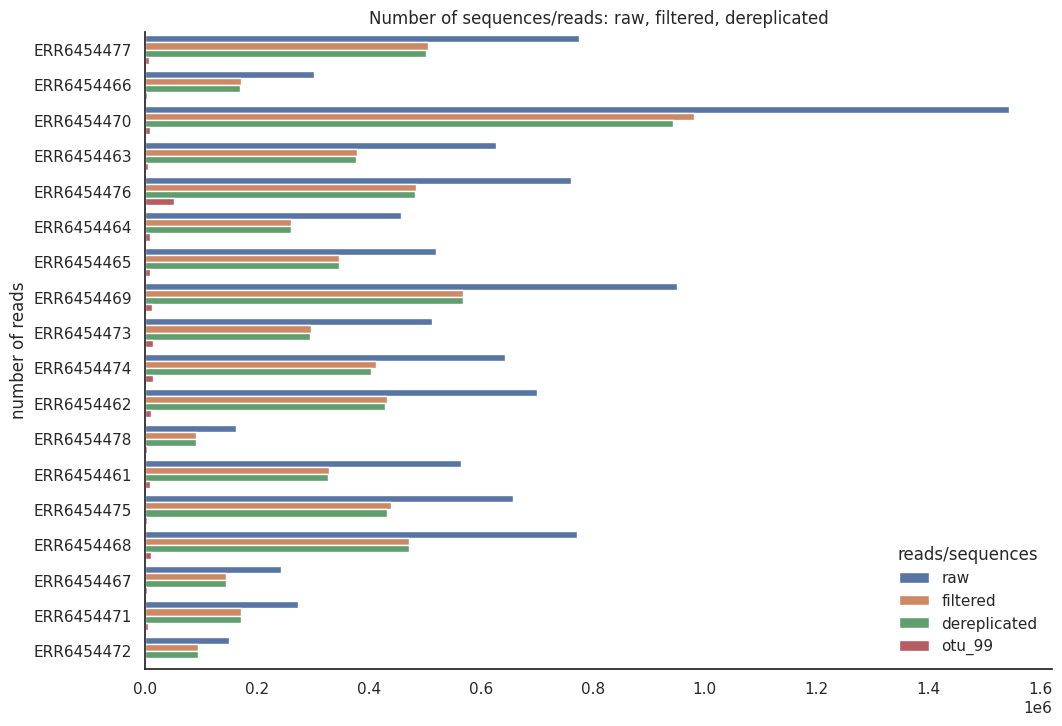

In [26]:
# Plotting number of reads comparison


# adjusting the data table for plotting
comp_plot = comp_df.melt(id_vars=['sample'], value_vars=['raw_reads', 
                                                         'filtered_seqs', 
                                                         'derep_seqs', 
                                                         'otu_99'])

# plotting code
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
plot = sns.barplot(data=comp_plot, y='sample', x="value", hue='variable')
plot.set(xlabel='', 
         ylabel = 'number of reads',
         title ='Number of sequences/reads: raw, filtered, dereplicated')
sns.despine()

# adjusting legend
h, l = plot.get_legend_handles_labels()
plot.legend(handles=h, 
                  labels=['raw', 'filtered', 'dereplicated', 'otu_99'], 
                  title='reads/sequences', 
                  loc="lower right", 
                  frameon=False);

### Length of the raw reads

### Length of the dereplicated reads

In [ ]:
# Creating a function for counting reads based on the lenght 

def get_reads_length_fasta(path):
    reads_length = {'less_4000': 0, 
                    '4000_5000': 0, 
                    'more_5000': 0
                   }

    with open(path,'rt') as f:
        for line in f:
            line_cleaned = line.replace('\n', '')
            if line_cleaned.startswith(('A', 'C',  'T', 'G')) and line_cleaned.isalpha():
                if len(line_cleaned) < 4000:
                    reads_length['less_4000'] += 1
                if 4000 <= len(line_cleaned) <= 5000:
                    reads_length['4000_5000'] += 1
                if len(line_cleaned) > 5000:
                    reads_length['more_5000'] += 1
    return reads_length

In [ ]:
path = '../raw_data/denoise/Jamy_2022/rDNA/cell/asv_seqs_ERR6454461.fasta'

output = get_reads_length_fasta(path)

output

In [ ]:
# Creating table with length distribution of the reads

directory = '../raw_data/PacBio/Suthaus_2022_rDNA/cell/'

paths = get_paths(directory)
data = {}

for path in paths:
    sample_name = path.split('/')[-1].split('.')[0].split('_')[0]
    data[sample_name] = get_reads_length(path)

df_length = pd.DataFrame.from_dict(data)
df_length = df_length.T
df_length = df_length.rename(columns={'less_3000': 'less_than_3000', 
                        '3000_6000': 'between_3000-6000', 
                        'more_6000': 'more_than_6000'})